In [2]:
import math
import random
from typing import List, Tuple

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical

In [3]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import collections
Batch = collections.namedtuple('batch', field_names=['state', 'log_prob', 'entropy', 'next_state', 'reward', 'done'])

In [5]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
print(device)

cuda


In [6]:
env_name = "CartPole-v0"
env = gym.make(env_name)
print(env.reset())
print(type(env.reset()))

[0.00752178 0.02814757 0.03313075 0.02865447]
<class 'numpy.ndarray'>


In [7]:
class Actor(nn.Module):
    def __init__(self, input_shape, output_shape):
        super(Actor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_shape[0], 128),
            nn.ReLU(),
            nn.Linear(128, output_shape),                       
            nn.Softmax(dim=-1)
        )

    def forward(self, state):
        logit = self.net(state)        
        return logit

In [8]:
input_shape = env.observation_space.shape
output_shape = env.action_space.n
test_actor = Actor(input_shape, output_shape).to(device)

In [9]:
class Critic(nn.Module):
    def __init__(self, input_shape):
        super(Critic, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_shape[0], 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        value = self.net(x)
        return value

In [10]:
def get_sample(batch, batch_size):
    state, log_prob, entropy, next_state, reward, done = zip(*[batch[idx] for idx in range(batch_size)])

    return np.array(state), np.array(log_prob), np.array(entropy), np.array(next_state), np.array(reward), np.array(done)

In [202]:
class A2CAgent:
    def __init__(self, env, gammma, entropy_weight):
        self.BATCH_SIZE = 128
        self.env = env
        #self.state = env.reset()
        self.gamma = gammma
        self.entropy_weight = entropy_weight

        input_shape = self.env.observation_space.shape
        n_actions = self.env.action_space.n
        self.actor = Actor(input_shape, n_actions).to(device)
        self.critic = Critic(input_shape).to(device)

        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-4)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3)

        self.batch = collections.deque(maxlen=self.BATCH_SIZE)
        
    def step(self):               
        state = self.env.reset()
        total_reward = 0
        while True:          
            state_tensor = torch.tensor(state, dtype=torch.float).to(device)
            logit = self.actor(state_tensor)
            dist = Categorical(logit)
            action = dist.sample()
            action_np = action.cpu().detach().numpy()
            
            log_prob = dist.log_prob(action)
            log_prob = log_prob.cpu().detach().numpy()
            entropy = dist.entropy()
            entropy = entropy.cpu().detach().numpy()
            next_state, reward, done, _ = self.env.step(action_np)  
            '''
            state_tensor = torch.tensor(state, dtype=torch.float).to(device)
            logit = self.actor(state_tensor).cpu().detach().numpy()
            action = np.random.choice(len(logit), p=logit)
            log_prob = np.log(logit)
            entropy = -1 * logit * log_prob
            next_state, reward, done, _ = self.env.step(action)  
            '''
            batch = Batch(state, log_prob, entropy, next_state, reward, done)
            self.batch.append(batch)
            state = next_state
            total_reward += reward
            if done:
                break

        return total_reward

    def update_model(self):
        state, log_prob, entropy, next_state, reward, done = get_sample(self.batch, len(self.batch))

        mask = 1 - done
        state_tensor = torch.tensor(state, dtype=torch.float).to(device)
        next_state_tensor = torch.tensor(next_state, dtype=torch.float).to(device)
        state_value = self.critic(state_tensor)
        # If done, state_action_value = reward
        next_state_value = self.critic(next_state_tensor).cpu().detach().numpy()    
        state_action_value = reward + self.gamma * next_state_value.reshape(-1) * mask        
        state_action_value_tensor = torch.tensor(state_action_value, dtype=torch.float).to(device)
        state_action_value_tensor = state_action_value_tensor.unsqueeze(-1)

        mseloss = nn.MSELoss()        
        critic_loss = mseloss(state_action_value_tensor, state_value)

        log_prob_tensor = torch.tensor(log_prob, dtype=torch.float, requires_grad=True).to(device)
        entropy_tensor = torch.tensor(entropy, dtype=torch.float, requires_grad=True).to(device)
        advantage = (state_action_value_tensor - state_value).detach()   
        actor_loss = -(advantage * log_prob_tensor).mean() + (-self.entropy_weight * entropy_tensor).mean()
        
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        return critic_loss, actor_loss

    def train(self, num_frames, plotting_interval = 200):
        critic_losses, actor_losses, scores = [], [], []        
        score = 0        
        for self.total_step in range(1, num_frames + 1):            
            reward = self.step()

            critic_loss, actor_loss = self.update_model()
            critic_losses.append(critic_loss)
            actor_losses.append(actor_loss)
            scores.append(reward)

            if self.total_step % plotting_interval == 0:
                self._plot(self.total_step, scores, actor_losses, critic_losses)
        self.env.close()

    def test(self):
        done = False
        score = 0
        frames = []
        state = self.env.reset()
        while not done:
            frames.append(self.env.render(mode="rgb_array"))
            state_tensor = torch.tensor(state, dtype=torch.float).to(device)
            logit = self.actor(state_tensor)
            dist = Categorical(logit)
            action = dist.sample()

            next_state, reward, done, _ = self.env.step(action.item())
            self.env.render()
            state = next_state
            score += reward
        print("score : ", score)
        self.env.close()

        return frames
    
    def _plot(
        self, 
        frame_idx: int, 
        scores: List[float], 
        actor_losses: List[float], 
        critic_losses: List[float], 
    ):
        """Plot the training progresses."""
        def subplot(loc: int, title: str, values: List[float]):
            plt.subplot(loc)
            plt.title(title)
            plt.plot(values)

        subplot_params = [
            (131, f"frame {frame_idx}. score: {np.mean(scores[-10:])}", scores),
            (132, "actor_loss", actor_losses),
            (133, "critic_loss", critic_losses),
        ]

        clear_output(True)
        plt.figure(figsize=(30, 5))
        for loc, title, values in subplot_params:
            subplot(loc, title, values)
        plt.show()


In [203]:
env_id = "CartPole-v0"
env = gym.make(env_id)
env.reset()

array([-0.01724021, -0.02230944,  0.00177417, -0.02530234])

In [204]:
num_frames = 100000
gamma = 0.9
entropy_weight = 1e-2
agent = A2CAgent(env, gamma, entropy_weight)

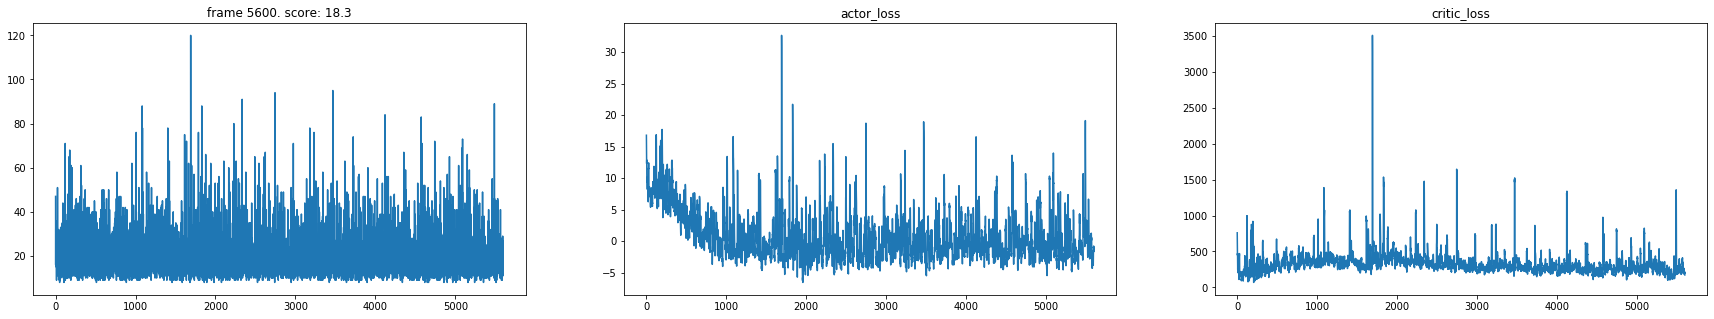

KeyboardInterrupt: 

In [205]:
agent.train(num_frames)

In [197]:
frames = agent.test()

score :  22.0
